In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import math
import pandas as pd
import copy

# константы генетического алгоритма
POPULATION_SIZE = 300   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.1        # вероятность мутации индивидуума
MAX_GENERATIONS = 300    # максимальное количество поколений

In [2]:
HISTORY = []
HISTORY2 = []

LAMDA0 = 0.00001
K = 50
v = 100
Time = 300
# (Т_огр)T0 = T_lim
T_lim = 150

e_1 = 4
e_1i = 2
e_tr = 6
e_tri = 2

{(0, 1): Text(0.6089899259979492, 0.5193223608059835, '1000'),
 (0, 2): Text(-0.38357980470650455, 0.4506750106938243, '500'),
 (0, 3): Text(0.0031607472572210416, 0.06762487279020324, '1000'),
 (1, 5): Text(0.33014555157047, 0.46959484248366473, '500'),
 (2, 5): Text(-0.6624241791339838, 0.4009474923715055, '300'),
 (3, 4): Text(0.043668420144915926, -0.8723992771905236, '500'),
 (4, 5): Text(-0.020356849543885835, -0.03896951779420471, '300'),
 (5, 6): Text(0.20328995927267154, 0.7600374381486887, '100'),
 (6, 7): Text(0.773401485241044, 0.005707933527116571, '100'),
 (6, 8): Text(-0.03536049673019609, 0.605554119304619, '100'),
 (6, 9): Text(0.01801365988467374, 0.009615133614473248, '50'),
 (7, 8): Text(-0.008247826893555132, -0.05748570960143884, '100'),
 (8, 9): Text(-0.7636356522499255, -0.05357850951408216, '50')}

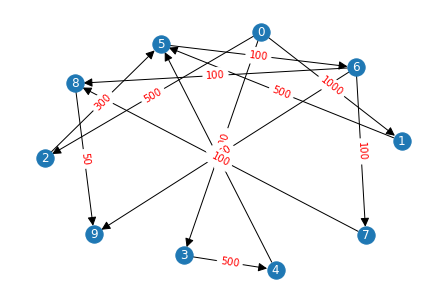

In [3]:
martx = [
[0, 1000, 500, 1000, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 500, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 300, 0, 0, 0, 0], 
[0, 0, 0, 0, 500, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 300, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 0, 100, 0, 0, 0], 
[0, 0, 0, 0, 0, 0, 0, 100, 100, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 100, 0], 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
] 

tasks_graph = nx.DiGraph(np.array(martx))
task_weight = [100, 300, 300, 300, 200, 150, 100, 100, 200, 100]

options = {
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 18,
}

pos = nx.spring_layout(tasks_graph, k=150,seed=20)
nx.draw(tasks_graph, pos, with_labels=True, font_color='white', **options)
nx.draw_networkx_edge_labels(tasks_graph, pos, {(x, y): z['weight'] for (x, y, z) in nx.to_edgelist(tasks_graph)},font_color='red')

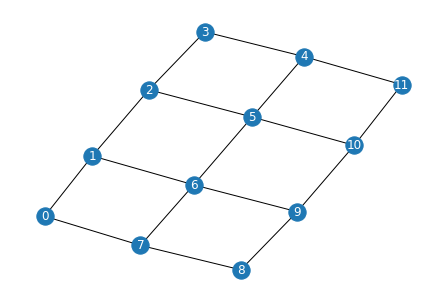

In [4]:
martx = [[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0], 
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], 
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0], 
[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], 
[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], 
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0], 
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], 
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]

network_graph = nx.Graph(np.array(martx))

net_power = [300,300,300,300,300,300,300,300,300,300,300,300]
epsi = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

E0 = [10,10,10,10,10,10,10,10,10,10,10,10]
EMax = [100,100,100,100,100,100,100,100,100,100,100,100]

pos = nx.spring_layout(network_graph, seed=100)
nx.draw(network_graph, pos, with_labels=True, font_color='white')

In [5]:
def FLamda(D):
    return LAMDA0 * 2 ** (K * D / 10)


def P(lamda):
    return math.exp(-lamda * Time)


def probabilityOfUptime(p, epsi):
    res = 1
    for i in range(len(p)):
        if p[i] > 0:
            res *= p[i] ** epsi[i]
    return res

In [6]:
def node_from_distribution(distribution, node):
        for i in range(len(distribution)):
            if node in distribution[i]:
                return i

In [7]:
class Individual():
    def __init__(self, *args):
        super().__init__(*args)
        self.convolution = 0
        self.f = 0
        self.Z = 100000000
        self.E = []
        self.W = []
        self.T_task = 0
        self.T_NET = 0
        self.distribution = []
        self.short_path = []

    def __str__(self):
        return f'''Cвертка : {self.convolution},\n 
ВБР: {self.p0}, Энергопотребление : {self.Z},\n 
Распределение: {self.distribution}, \n
Нагруженность на узлы: {self.W}, \n
Производительность узлов: {net_power}\n
трудоемкость задач: {task_weight}\n
D {self.D}\n
Сколько времени уделено задаче (T_task) {self.T_task}\n
Сколько времени работает узел (T_NET) {self.T_NET} \n
Энергопотребление на каждый узел (Ei) : {self.E}
Кратчайший путь (short_path) {self.short_path}\n
# Сколько каждый узел должен обработать задач \n
{self.v_task_to_node}\n
# Сколько каждый узел должен отправить\n
{self.v_sent_to_node} \n
# Сколько каждый узел должен принять \n
{self.v_reseive_to_node}\n
'Задача1задача2:ПутьВГрафеСети {self.paths}' \n\n\n '''

    def set_distribution(self, distr):
        self.distribution = distr
        self.create_paths()
        self.calculation_of_parameters()

    def create_paths(self):
        # 'Задача1задача2:ПутьВГрафеСети'
        self.paths = {}
        # Словарь путей
        # Задача:Узел
        self.relationship = {}
        for start, end, weight in nx.to_edgelist(tasks_graph):
            self.relationship[start] = node_from_distribution(self.distribution, start)
            self.relationship[end] = node_from_distribution(self.distribution,end)
            if self.relationship[start] == self.relationship[end]:
                self.paths[str(start) + str(end)] = [self.relationship[start]]
            else:
                self.paths[str(start) + str(end)] = random.choice(
                    [item for item in nx.all_shortest_paths(network_graph, self.relationship[start], self.relationship[end])])


    def calculation_of_parameters(self): 
        # Подсчет трудоемкости
        W = [0 for _ in range(len(net_power))]

        # Сколько каждый узел должен обработать задач 
        self.v_task_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен отправить
        self.v_sent_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен принять 
        self.v_reseive_to_node = [0 for _ in range(len(net_power))]

        for start, end, weight in nx.to_edgelist(tasks_graph):
            """
            start - задача начало
            end - задача конец
            weight - то сколько должено быть прередано из одной задачи в другую 
            """
            if not len(self.paths[str(start) + str(end)]) == 1:
                temp = self.paths[str(start) + str(end)].copy()
                # task_weight - нагрузка на выполнение задачи 
                #Оброботка нагрузки начала пути 
                W[temp[0]] += task_weight[start] + weight['weight']

                self.v_sent_to_node[temp[0]] += weight['weight']
                self.v_task_to_node[temp[0]] += task_weight[start]
                #Оброботка нагрузки конца пути
                W[temp[-1]] += task_weight[end] + weight['weight']

                self.v_reseive_to_node[temp[-1]] += weight['weight']
                self.v_task_to_node[temp[-1]] += task_weight[start]

                temp.pop(0)
                temp.pop(-1)
                # Оброботка нагрузки всех остальных узлов в пути
                for i in temp:
                    W[i] += 2 * weight['weight']
                    self.v_sent_to_node[i] += weight['weight']
                    self.v_reseive_to_node[i] += weight['weight']
            else:
                W[self.relationship[start]] += task_weight[start]
                self.v_task_to_node[self.relationship[start]] += task_weight[start]

                W[self.relationship[end]] += task_weight[end]
                self.v_task_to_node[self.relationship[end]] += task_weight[end]

        # Оценка времени задач изначально
        arr = ([a for a in nx.all_simple_paths(tasks_graph, 0, len(task_weight) - 1)])
        arr.sort(key=lambda x: len(x), reverse=True)
        T_task = [0 for _ in range(len(task_weight))]

        for task in arr[0]:
            T_task[task] = T_lim / len(arr[0])

        # Оценка времени задач
        for path_task in arr[1:]:
            sum_t = 0
            temp = []
            for task in path_task:
                if T_task[task] == 0:
                    temp.append(task)
                sum_t += T_task[task]
            for task in temp:
                T_task[task] = (T_lim - sum_t) / len(temp)

        T_NET = [0 for _ in range(len(net_power))]
        # Оценка времени сети
        for start, end, weight in nx.to_edgelist(tasks_graph):
            path_net = self.paths[str(start) + str(end)].copy()
            if len(path_net) == 1:
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start])
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start], T_NET[path_net[-1]])
            else:
                # Обработка поледего узла в пути
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = T_task[end]
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_NET[path_net[-1]])
                # Если будет > 1 узла то
                for node in path_net[:-1]:
                    if T_NET[node] == 0:
                        T_NET[node] = T_task[start] / len(path_net[:-1])
                    else:
                        T_NET[node] = min(T_NET[node], T_task[start] / len(path_net[:-1]))
            
            D = [0. for i in range(len(net_power))]

            for i in range(len(net_power)):
                if not T_NET[i] == 0:
                    D[i] = W[i] / (net_power[i] * T_NET[i])

        # Оценка кр. пути задач для сети
        special_t = T_lim / len(arr[0])
        for node in range(len(net_power)):
            if len(set(self.distribution[node]) & set(arr[0])) > 1:
                T_NET[node] = special_t * len(set(self.distribution[node]) & set(arr[0]))
        flag = True
        for d in D:
            if d > 1:
                flag = False
        
        if flag:
            lamda = [FLamda(D[i]) for i in range(len(net_power))]
            p = [P(L) for L in lamda]
            p0 = probabilityOfUptime(p, epsi)
        else:
            p0 = -1

        #Вычислительного устройства(ВУ). computing devices - cd
        #E_cd = [0 for _ in range(len(net_power))]
        #Устройства передачи данных (УПД). data transmission devices - dtd
        #E_dtd = [0 for _ in range(len(net_power))]
        #
        #for i in range(len(net_power)):
        #    E_cd[i] = e_1 * (self.v_task_to_node[i]/net_power[i]) + e_1 * (self.v_reseive_to_node[i]/net_power[i]) + e_1 * (self.v_sent_to_node[i]/net_power[i]) - e_1i*(T_lim - (self.v_task_to_node[i]/net_power[i]) +  (self.v_reseive_to_node[i]/net_power[i]) + (self.v_sent_to_node[i]/net_power[i]))
        #for i in range(len(net_power)):
        #    E_dtd[i] = e_tr * (self.v_reseive_to_node[i]/v) + e_tr * (self.v_sent_to_node[i]/v) + e_tri * (T_lim - (self.v_reseive_to_node[i]+self.v_sent_to_node[i])/v)
        #
        #if flag: 
        #    E = sum(E_cd) + sum(E_dtd)
        #else:
        #    E = 10000000000

        if flag:
            E = [0 for _ in range(len(net_power))] 
            Z = [0 for _ in range(len(net_power))] 
            for i in range(len(net_power)):
                E[i] = E0[i] + (EMax[i] - E0[i]) * D[i]
                Z[i] = E[i]*T_NET[i] + (T_lim - T_NET[i])* E0[i]
            
            Z = sum(Z)
        else:
            E = []
            Z = 10000000000

        convolution = p0 * (1/Z)

        self.convolution = round(convolution * 10 ** 6, 5)
        self.p0 = p0
        self.Z = Z
        self.E = E
        self.W = W
        self.D = D
        self.T_task = T_task
        self.T_NET = T_NET
        self.short_path = arr[0]
    
    def __eq__(self, other):
        c0 = 0
        for node in range(len(net_power)):
            c = 0
            for task in self.distribution[node]:
                if task in other.distribution[node]:
                    c +=1
            if c == len(self.distribution[node]):
                c0 +=1
        
        if c0 == len(net_power):
            return True

        return False

In [8]:
def create_random_distribution(COUNT_NODE_NET, COUNT_NODE_TASK, CONST_DISTRIBUTION={}):
    random_task_distribution = [[] for _ in range(COUNT_NODE_NET)]
    temp = [x for x in range(COUNT_NODE_TASK)]
    for node, task in CONST_DISTRIBUTION.items():
        random_task_distribution[node].append(temp.pop(task))
    while not len(temp) == 0:
        random_task_distribution[random.randint(0, COUNT_NODE_NET - 1)].append(
            temp.pop(random.randint(0, len(temp) - 1)))
    return random_task_distribution

In [9]:
def individualCreator():
    temp = Individual()
    dist = create_random_distribution(len(net_power), len(task_weight))
    temp.set_distribution(dist)
    return temp
 
def populationCreator(n = 0):
    return list([individualCreator() for i in range(n)])

In [10]:
def dominates(m1, m2): 
    return m1.p0 >= m2.p0 and m1.Z <= m2.Z and (m1.p0 > m2.p0 or m1.Z < m2.Z)

def crossing(p1,p2):
    #Скрещивание распределения
    new_distr = random.choices(range(len(task_weight)), k=random.randint(1,len(task_weight)))
    dist1, dist2 = p1.distribution.copy(), p2.distribution.copy()
    for task in new_distr:
        i1, i2 = node_from_distribution(p1.distribution, task), node_from_distribution(p2.distribution, task)
        if not i1 == i2:
            dist1[i1].remove(task); dist2[i2].remove(task)
            dist1[i2].append(task); dist2[i1].append(task)

    child1 = Individual()
    child1.set_distribution(dist1)
    child2 = Individual()
    child2.set_distribution(dist2)
    return [child1, child2]

def mutation(ind, indpb=0.01):
    mutant = Individual()
    dist = ind.distribution.copy()
    for task in range(len(task_weight)):
        if random.random() <= indpb:
            i = node_from_distribution(ind.distribution,task)
            dist[i].remove(task)
            j = i
            while j == i:
                j = random.randint(0, len(net_power)-1)
            dist[j].append(task)
    mutant.set_distribution(dist)
    return mutant

In [11]:
def GA(GENERATIONS = MAX_GENERATIONS):
    statistic = {
        'maxF': [],
        'minE': [],
        'avgF': [],
        'avgE': [],
        'unique': []
    }

    population = populationCreator(n=POPULATION_SIZE) 
    generationCounter = 0
    
    while generationCounter < GENERATIONS:
        generationCounter += 1

        P_t = population.copy()
        Q_t = []

        # Скрещивание 
        while len(Q_t) < POPULATION_SIZE:
            parent1 = copy.deepcopy(random.choice(population))
            parent2 = copy.deepcopy(random.choice(population))

            if random.random() <= P_CROSSOVER:
                Q_t+=crossing(parent1, parent2)
        
        # Мутация  
        for i in range(len(Q_t)):
            if random.random() < P_MUTATION:
                Q_t[i] = mutation(Q_t[i], indpb=1.0/len(task_weight))

        R_t = P_t + Q_t

        rank = [0 for _ in range(len(R_t)+1)]
        for i in range(len(R_t)):
                for j in range(i+1, len(R_t)):
                    if dominates(R_t[i], R_t[j]):
                        rank[j] += 1
                    elif dominates(R_t[j], R_t[i]):
                        rank[i] += 1

        F_rank = [[] for _ in range(max(rank)+1)]
        for r, ind in sorted(zip(rank, R_t), key=lambda x: x[0]):
            F_rank[r].append(ind)


        nex_pop = []
        r = 0
        while len(nex_pop) < POPULATION_SIZE:
            if len(F_rank[r]) + len(nex_pop) <= POPULATION_SIZE:
                for ind in F_rank[r]:
                    nex_pop.append(ind)
            elif len(F_rank[r]) > 0:
                i = 0
                while len(nex_pop) < POPULATION_SIZE:
                    nex_pop.append(F_rank[r][i])
                    i+=1
            r+=1
        population = nex_pop.copy()

        set_pop = []
        for element in population:
            flag = True
            for el in set_pop:
                if el == element:
                    flag = False
            if flag:
                set_pop.append(element)

        statistic['unique'].append(len(set_pop))
        if (len(set_pop)) < POPULATION_SIZE // 3:
            set_pop += [] + populationCreator(n=POPULATION_SIZE - (len(set_pop))) 
            population = set_pop.copy()

        print(f"Поколение {generationCounter}: {len(population)}")
        data = []


        for i in range(len(population)):
            data.append([population[i].p0,population[i].Z])

        data = np.array(data)
        df = pd.DataFrame({
            'ВБР': data[:,0],
            'Энергопотребление': data[:,1]
        })

        statistic['maxF'].append(pd.Series(data[:,0]).max())
        statistic['avgF'].append(pd.Series(data[:,0]).mean())

        statistic['minE'].append(pd.Series(data[:,1]).min())
        statistic['avgE'].append(pd.Series(data[:,1]).mean())

        HISTORY.append(population)
        

        print(df.describe())
        print()
    return statistic, population

In [12]:
def pareto_frontier(X, Y):
    sorted_indices = sorted(range(len(X)), key=lambda i: X[i],  reverse=True)
    pareto_frontier_indices = [sorted_indices[0]]
    for i in range(1, len(sorted_indices)):
        idx = sorted_indices[i]
        if Y[idx] < Y[pareto_frontier_indices[-1]]:
            pareto_frontier_indices.append(idx)
    pareto_frontier_X = [X[i] for i in pareto_frontier_indices]
    pareto_frontier_Y = [Y[i] for i in pareto_frontier_indices]
    return pareto_frontier_X, pareto_frontier_Y


def print_population(population):
    set_pop = []
    for i in range(len(population)):
        flag = True
        for j in range(i + 1, len(population)):
            if population[i] == population[j]:
                flag = False
        flag2= True
        for j in range(len(set_pop)):
            if population[i] == set_pop[j]:
                flag = False
        if flag2 and flag and population[i].p0>0:
            set_pop.append(population[i])


    X = [x.p0 for x in set_pop]
    Y = [y.Z for y in set_pop]

    pareto_X, pareto_Y = pareto_frontier(X, Y)

    plt.scatter([x.p0 for x in set_pop],[y.Z for y in set_pop], label='Все точки')
    plt.scatter(pareto_X, pareto_Y, color='red', label='Множество Парето')
    plt.xlabel('P0')
    plt.ylabel('E')
    plt.title('Множество Парето')
    plt.legend()
    plt.show()

    population_ = [x for x in set_pop if x.p0 > 0]
    rank = [0 for _ in range(len(population_))]
    for i in range(len(population_)):
        for j in range(i+1, len(population_)):
            if dominates(population_[i], population_[j]):
                rank[j] += 1
            elif dominates(population_[j], population_[i]):
                rank[i] += 1

    F_rank = [[] for _ in range(max(rank)+1)]
    for r, ind in sorted(zip(rank, population_), key=lambda x: x[0]):
        F_rank[r].append(ind)
    
    print(max(set_pop, key = lambda ind: ind.f))
    print(min(set_pop, key = lambda ind: ind.E))

    

In [13]:
def print_statistic(statistic):
    p = np.arange(0,len(statistic['maxF']),1)
    y = [y for y in statistic['unique']]
    plt.xlabel('Поколение')
    plt.ylabel('Количесво уникальных индивидов')
    plt.plot(p,y,'r--')
    plt.show()


    p = np.arange(0,len(statistic['maxF']),1)
    y = [y for y in statistic['avgF']]
    plt.xlabel('Поколение')
    plt.ylabel('avgF')
    plt.plot(p,y,'r--')
    plt.show()

In [14]:
RANDOM_SEED = 488204665213841
random.seed(RANDOM_SEED)

statistic, population = GA(MAX_GENERATIONS)

Поколение 1: 300
         ВБР  Энергопотребление
count  300.0       3.000000e+02
mean    -1.0       1.000000e+10
std      0.0       0.000000e+00
min     -1.0       1.000000e+10
25%     -1.0       1.000000e+10
50%     -1.0       1.000000e+10
75%     -1.0       1.000000e+10
max     -1.0       1.000000e+10

Поколение 2: 300
         ВБР  Энергопотребление
count  300.0       3.000000e+02
mean    -1.0       1.000000e+10
std      0.0       0.000000e+00
min     -1.0       1.000000e+10
25%     -1.0       1.000000e+10
50%     -1.0       1.000000e+10
75%     -1.0       1.000000e+10
max     -1.0       1.000000e+10

Поколение 3: 300
         ВБР  Энергопотребление
count  300.0       3.000000e+02
mean    -1.0       1.000000e+10
std      0.0       0.000000e+00
min     -1.0       1.000000e+10
25%     -1.0       1.000000e+10
50%     -1.0       1.000000e+10
75%     -1.0       1.000000e+10
max     -1.0       1.000000e+10

Поколение 4: 300
         ВБР  Энергопотребление
count  300.0       3.000000e+02
m

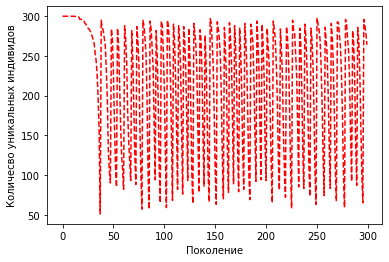

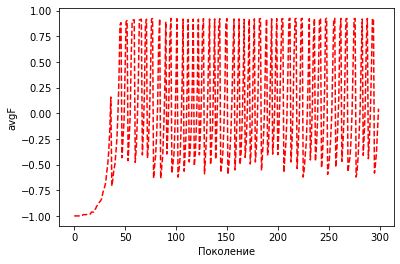

In [15]:
print_statistic(statistic)

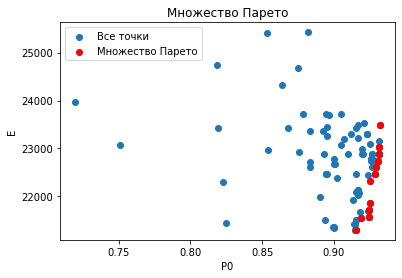

Cвертка : 41.07535,
 
ВБР: 0.9291244649698247, Энергопотребление : 22620.0,
 
Распределение: [[], [], [9, 6], [8, 7], [], [5], [2], [], [], [3, 0, 1], [4], []], 

Нагруженность на узлы: [0, 0, 950, 1050, 0, 1800, 1400, 0, 0, 3000, 2200, 0], 

Производительность узлов: [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]

трудоемкость задач: [100, 300, 300, 300, 200, 150, 100, 100, 200, 100]

D [0.0, 0.0, 0.1688888888888889, 0.18666666666666668, 0.0, 0.32, 0.12444444444444444, 0.0, 0.0, 0.5333333333333333, 0.39111111111111113, 0.0]

Сколько времени уделено задаче (T_task) [18.75, 37.5, 37.5, 18.75, 18.75, 18.75, 18.75, 18.75, 18.75, 18.75]

Сколько времени работает узел (T_NET) [0, 0, 37.5, 37.5, 0, 18.75, 37.5, 0, 0, 37.5, 18.75, 0] 

Энергопотребление на каждый узел (Ei) : [10.0, 10.0, 25.200000000000003, 26.8, 10.0, 38.8, 21.2, 10.0, 10.0, 58.0, 45.2, 10.0]
Кратчайший путь (short_path) [0, 3, 4, 5, 6, 7, 8, 9]

# Сколько каждый узел должен обработать задач 

[0, 0, 750, 700, 

In [16]:
print_population(population)

In [17]:
#import dill
#dill.dump_session('NSGA-II-2.db')
#dill.load_session('NSGA-II-2.db')

In [18]:
def print_fron_rang_1(population):
    set_pop = []
    for i in range(len(population)):
        flag = True
        for j in range(i + 1, len(population)):
            if population[i] == population[j]:
                flag = False
        flag2= True
        for j in range(len(set_pop)):
            if population[i] == set_pop[j]:
                flag = False
        if flag2 and flag and population[i].p0>0:
            set_pop.append(population[i])

    population_ = [x for x in set_pop if x.p0 > 0]
    rank = [0 for _ in range(len(population_))]
    for i in range(len(population_)):
        for j in range(i+1, len(population_)):
            if dominates(population_[i], population_[j]):
                rank[j] += 1
            elif dominates(population_[j], population_[i]):
                rank[i] += 1

    F_rank = [[] for _ in range(max(rank)+1)]
    for r, ind in sorted(zip(rank, population_), key=lambda x: x[0]):
        F_rank[r].append(ind)

    for ind in F_rank[0]:
        print(ind)


In [19]:
print_fron_rang_1(population)

Cвертка : 41.07535,
 
ВБР: 0.9291244649698247, Энергопотребление : 22620.0,
 
Распределение: [[], [], [9, 6], [8, 7], [], [5], [2], [], [], [3, 0, 1], [4], []], 

Нагруженность на узлы: [0, 0, 950, 1050, 0, 1800, 1400, 0, 0, 3000, 2200, 0], 

Производительность узлов: [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]

трудоемкость задач: [100, 300, 300, 300, 200, 150, 100, 100, 200, 100]

D [0.0, 0.0, 0.1688888888888889, 0.18666666666666668, 0.0, 0.32, 0.12444444444444444, 0.0, 0.0, 0.5333333333333333, 0.39111111111111113, 0.0]

Сколько времени уделено задаче (T_task) [18.75, 37.5, 37.5, 18.75, 18.75, 18.75, 18.75, 18.75, 18.75, 18.75]

Сколько времени работает узел (T_NET) [0, 0, 37.5, 37.5, 0, 18.75, 37.5, 0, 0, 37.5, 18.75, 0] 

Энергопотребление на каждый узел (Ei) : [10.0, 10.0, 25.200000000000003, 26.8, 10.0, 38.8, 21.2, 10.0, 10.0, 58.0, 45.2, 10.0]
Кратчайший путь (short_path) [0, 3, 4, 5, 6, 7, 8, 9]

# Сколько каждый узел должен обработать задач 

[0, 0, 750, 700, 